In [2]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

DIR_DATOS = """./"""
PARQUET_FILE = """datos_urgencia_consolidados.parquet"""
CSV_OUTPUT_FILE = """datos_urgencia_consolidados_agrupados.csv"""
duckdb.read_parquet("""datos_urgencia_consolidados.parquet""")

def find_peak_week(df, column,window = 5):
    if window % 2 == 0:
        print("please chooose an odd lenght window")
        return
    n = df.shape[0]
    #df_copy = df.copy()
    compare = df[column].drop([k for k in range(window)]).reset_index(drop= True) - df[column].drop([n-window + k for k in range(window)]).reset_index(drop= True)
    compare= compare.reset_index(drop= True)
    return np.argmax(compare)+window //2 

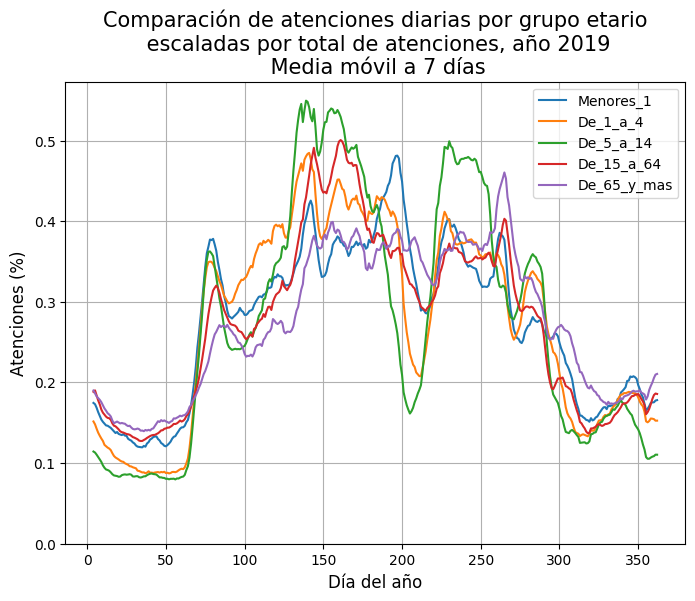

In [6]:
#Comparacion de datos para diferentes grupos etarios para un año fijo
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#WE scale the data dividing by the total yearly demand in order to distinguish behaviour
df = duckdb.sql("""
select 
      year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
--where IdCausa =6 and CodigoRegion = 5
and fecha like '%2019' 
--and dayofyear(strptime(fecha, '%d/%m/%Y')) <=365
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by year, nrodia
order by year, nrodia
""").df()

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
#colors = ['r', 'g', 'b','orange', 'pink']
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for column in targets:
    plt.plot(df['nrodia'],100*df[column].rolling(7,center=True).mean()/float(sum(df[column]))) # c = color)
plt.legend(targets)
ax.set_ylim(ymin=0)
ax.grid()
ax.set_title('Comparación de atenciones diarias por grupo etario\n escaladas por total de atenciones, año 2019\n Media móvil a 7 días', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones (%)', fontsize = 12)
plt.show()